In [1]:
import ee
import datetime
import os
import itertools
import sys

from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

In [3]:
# define basic parameters
year_range = [f'{i}_{i+2}' for i in range(1990,2020,3)]

In [4]:
year_range

['1990_1992',
 '1993_1995',
 '1996_1998',
 '1999_2001',
 '2002_2004',
 '2005_2007',
 '2008_2010',
 '2011_2013',
 '2014_2016',
 '2017_2019']

In [5]:
North_China_Plain = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

### calculate the area change of the classification

##### Import my result, GAIA and GIP_2015 

In [6]:
# get the GAIA classification product
GAIA_img = ee.Image("users/wangjinzhulala/North_China_Plain_Python/Reference_classification/GAIA_NCP")

# get the Global Impervious Surface of 2015
GIP_2015 = ee.Image("users/wangjinzhulala/North_China_Plain_Python/Reference_classification/Global_Impervious_Surface_2015_NCP")\
             .remap([1,2],[0,1]).rename('b1')

# define the modes
modes = ['forward_backward','backward_forward','only_forward','only_backward']

##### Calculate the area change from my product

In [7]:
Stats_my = {}

for mode in modes:
    for year in year_range:
        img = ee.Image(f"users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/{mode}_Window_3_It_9_{year}")
        
        # get the pixel count of my classifications
        Stats = img.reduceRegion(reducer   = ee.Reducer.sum(), 
                                 geometry  = North_China_Plain.geometry().bounds(), 
                                 scale     = 30, 
                                 maxPixels = int(1e13)).getInfo()

        Stats_my[(mode,year)] = [int(Stats['b1'])]
                                 
        # print out the process
        print(f'{mode}_{year} finished!')

forward_backward_1990_1992 finished!
forward_backward_1993_1995 finished!
forward_backward_1996_1998 finished!
forward_backward_1999_2001 finished!
forward_backward_2002_2004 finished!
forward_backward_2005_2007 finished!
forward_backward_2008_2010 finished!
forward_backward_2011_2013 finished!
forward_backward_2014_2016 finished!
forward_backward_2017_2019 finished!
backward_forward_1990_1992 finished!
backward_forward_1993_1995 finished!
backward_forward_1996_1998 finished!
backward_forward_1999_2001 finished!
backward_forward_2002_2004 finished!
backward_forward_2005_2007 finished!
backward_forward_2008_2010 finished!
backward_forward_2011_2013 finished!
backward_forward_2014_2016 finished!
backward_forward_2017_2019 finished!
only_forward_1990_1992 finished!
only_forward_1993_1995 finished!
only_forward_1996_1998 finished!
only_forward_1999_2001 finished!
only_forward_2002_2004 finished!
only_forward_2005_2007 finished!
only_forward_2008_2010 finished!
only_forward_2011_2013 finish

In [17]:
Area_df = pd.DataFrame(Stats_my).stack(1).reset_index().drop(['level_0'],1)
Area_df.columns = ['year_range'] + list(Area_df.columns)[1:]
Area_df

,year_range,backward_forward,forward_backward,only_backward,only_forward
0,1990_1992,70044188,64144522,86992789,44463287
1,1993_1995,87042579,78182338,99165204,54003539
2,1996_1998,99538659,91296920,118470999,61389290
3,1999_2001,103553309,95251043,129534484,66117022
4,2002_2004,110479558,102076019,137081066,75113410
5,2005_2007,118244499,110143733,153025319,86646249
6,2008_2010,129340522,118845175,170833752,99819361
7,2011_2013,136366268,128094086,187228332,115091745
8,2014_2016,160557810,145370707,194825848,139182086
9,2017_2019,172172346,157973045,205187135,145159993


##### Calculate the area change from GAIA

In [19]:
# get the GAIA area change
GAIA_value = dict(zip(range(1985,2019),range(34,0,-1)))

# add {2019:1} to the dictionary, because GAIA does not 
# extend to 2019, we just use its latest pixel of 2018
GAIA_value.update({2019:1})

# here we get each end year (1992,1995,...,2019) from GAIA
# set the target year's value to 1, others to 0
GAIA_each_year = [ee.Image(GAIA_img.gte(GAIA_value[year])) 
                  for year in range(1992,2020,3)]

In [20]:
# get the area change from GAIA product
Stats_GAIA = [img.reduceRegion( reducer   = ee.Reducer.sum(), 
                                geometry  = North_China_Plain.geometry().bounds(), 
                                scale     = 30, 
                                maxPixels = int(1e13))
             for img in GAIA_each_year]

Stats_GAIA = [int(st.getInfo()['b1']) for st in Stats_GAIA]

##### Calculate the area of GIP_2015

In [21]:
Stats_GIP_2015 = GIP_2015.reduceRegion( reducer   = ee.Reducer.sum(), 
                                geometry  = North_China_Plain.geometry().bounds(), 
                                scale     = 30, 
                                maxPixels = int(1e13))
                                       
Stats_GIP_2015 = int(Stats_GIP_2015.getInfo()['b1'])                                     

##### Add all area change in one df

In [27]:
# # add GAIA
# Area_df['GAIA'] = Stats_GAIA

# # add GIP 2015 and set the rest to nan
# Area_df['GIP_2015'] = np.nan
# Area_df.at[8,'GIP_2015'] = Stats_GIP_2015

# # # convert the df to long format
# Area_stack = pd.DataFrame(Area_df.set_index('year_range').stack()).reset_index()
# Area_stack.columns = ['year_range', 'type', 'count']

# # save to dis
# Area_stack.to_csv('./Result/Area_change.csv',index=False)

# read csv
Area_stack = pd.read_csv('./Result/Area_change.csv')

#### Observe that there is a noticibel dirrerence in total area between my result and the GAIA

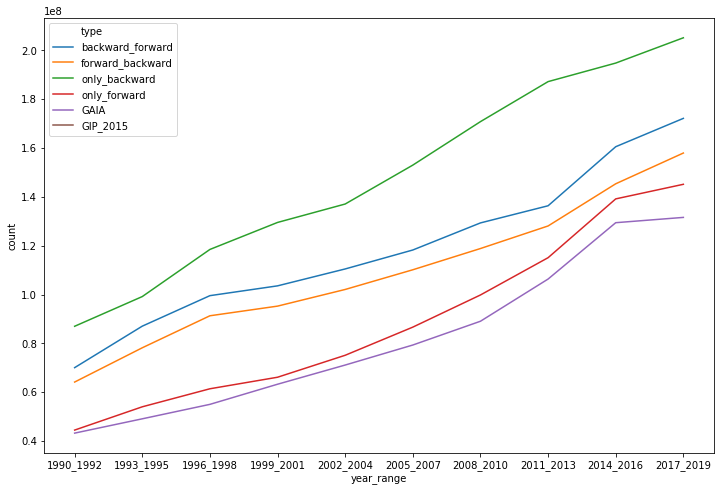

In [28]:
plt.figure(figsize=(12,8))

sns.lineplot(data=Area_stack,x='year_range',y='count',hue='type')